IDEAS https://www.kaggle.com/bandiatindra/telecom-churn-prediction

### Telco Customer Churn Prediction

Churn is one of the biggest problems facing any company nowadays. In a world in which the monthly subscription is one of the most used ways to attract customers, the effort to keep them in the service is very important

The dataset with which we are going to create the classification model is [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) from Kaggle.

First, we are going to import all the libraries necessary to create the model and open the .csv file. Let's see some information about the data.

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE

### First look at data

In [345]:
# Read the .csv file
path = '/Users/MacBookProCasa/Documents/Formación/Data_science/Python/Projects/Datasets/TelcoChurn'
data = pd.read_csv(path + '/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [346]:
# Display first 5 rows of the table
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [347]:
# Headers of columns
print('Columns header: ',data.columns)
print('\nNumber of columns: ',len(data.columns))

Columns header:  Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Number of columns:  21


In [348]:
# Analyse more info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [349]:
# Looking for null values
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

So far we have seen that almost all the data is an **object** data type. That means that we must to transform it by encoding, replacing **strings** to **integer** data types.

We also see that there are **21 features** and seems there are no **Nan** values. We should explore it in deep because sometimes there are empty fields with string without text.   

### Some feature engeniering

First, we will remove the feature "customerID" because it doesn't provide any information to the model.

Next and before transforming all features on numerical data type with "get_dummies" Pandas function, we apply a label encode to the target features "Churn". That is necessary to use this feature as "target" to train the model.

After that step and after taking a look at the rest of features, we decided to apply a one hot encoder to all "object" features (except "churn"). We will do with "get_dummies" function.

![hola](get_dummies.png)

Because there are 11 rows with no content in the "TotalCharge" feature, to encode that feature we have to remove that 11 rows.

In [350]:
# Drop "customerID" feature
data.drop(['customerID'], axis=1, inplace=True)

# Encode the target feature that is binary
data['Churn'] = data['Churn'].replace({'No': 0, 'Yes': 1})

# Find and remove rows with empty fields in the "TotalCharge" feature,
# and transform it as "int" because it was an "object" data type
data.drop(data[data['TotalCharges'] == " "].index, inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

# One hot encoder for all "object" features
num_col_before = data.shape[1]
print('Shape antes del mapeo: ', data.shape)
data = pd.get_dummies(data)
print('Shape después del mapeo: ', data.shape)
print('\n New columns: ', data.shape[1] - num_col_before)

Shape antes del mapeo:  (7032, 20)
Shape después del mapeo:  (7032, 46)

 New columns:  26


After applied get_dummie function, we see that there are 26 new columns. Every categorical or object feature was split into as many columns as there unique values. That helps the precision of the algorithm because of ranked columns.

### EDA

Now that we have our data transformed and ready as the input of the classification algorithm, we are going to analyse the data and get insights

Correlations analysis helps to determine which features influence the model most. By choosing the correct features the model will be more accurate.

#### Correlation

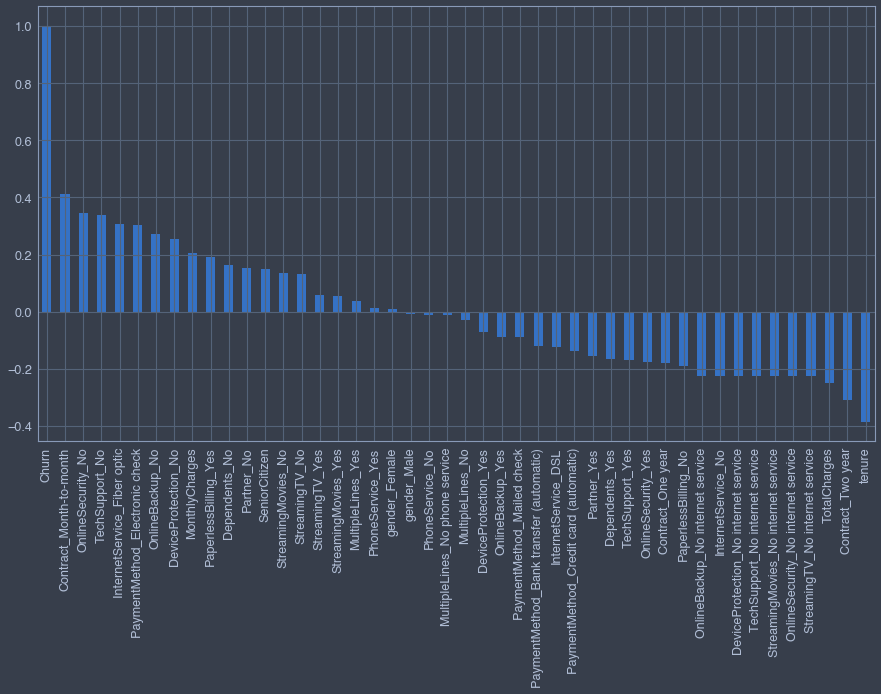

In [402]:
# Correlation chart
plt.figure(figsize=(15,8))

churn_corr = data.corrwith(data['Churn']).sort_values(ascending=False)
churn_corr.plot(kind='bar')

plt.show()

The plot above tells us that the features most positively correlated with the "Churn" target are:
- Contract_Month-to-month
- OnlineSecurity_No
- TechSupport_No

And those negative high correlated are:
- tenure
- Contract_Two year

This means that when a user has 1 in positive correlation features the probability of "Churn" is higher. And when has 1 in negative correlation features the probability of "Churn" decrease.

#### Target analysis

We are going to look at the "Churn" target feature.

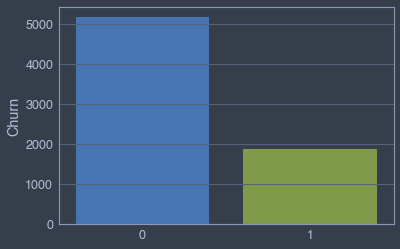

In [352]:
sns.barplot(x=['0','1'], y=data['Churn'].value_counts())
plt.show()

Clearly, the target is unbalanced. There are almost double "no churn" samples than "churn". We will have to create new "Churn" samples to improve the classificator.

#### Outliers

Because "tenure" (*Number of months the customer has stayed with the company*) is one of the most important features correlated with the target, and one of those which has numerical values and no binary, we are going to explore its outliers.

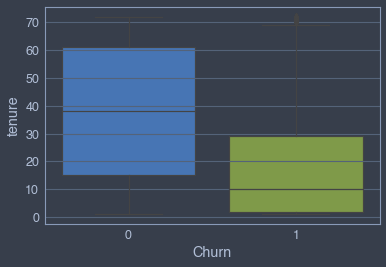

In [353]:
sns.boxplot(x=data['Churn'], y=data['tenure'])
plt.show()

We can see than users that continue (no churn) are in the company since between 20 and 60 months, and those churned were in the company between almost 0 and 30 months. There are many outliers in the churn users that we are going to explore.

In [354]:
# Quartils and IQR method to fin outliers
data_churn = data[data['Churn'] == 1]

Q1 = np.percentile(data_churn['tenure'], 25)
Q2 = np.percentile(data_churn['tenure'], 50)
Q3 = np.percentile(data_churn['tenure'], 75)

print('Q1',Q1, 'Q2',Q2, 'Q3', Q3)
IQR = Q3 - Q1
print('IQR',IQR)

Min = Q1 - 1.5 * IQR
Max = Q3 + 1.5 * IQR
print('\n')
print('Min: ',Min)
print('Max: ',Max)

outliers=[]
for value in data_churn['tenure']:
    if value < Min or value > Max:
        outliers.append(value)
print('\nOutliears: ', list(set(outliers)))

Q1 2.0 Q2 10.0 Q3 29.0
IQR 27.0


Min:  -38.5
Max:  69.5

Outliears:  [72, 70, 71]


In [355]:
churn_outliers = data_churn[(data_churn['tenure'] == list(set(outliers))[0]) | (data_churn['tenure'] == list(set(outliers))[1]) | (data_churn['tenure'] == list(set(outliers))[2])]['Churn']
print('Total outliers rows: ',churn_outliers.value_counts()[1])

Total outliers rows:  23


There are only outliers when churn is 1. And in that case, there are 23 rows affected with "tenure" higher than 70. We decide to try the model without these rows.

In [356]:
rows_before_drop = data.shape[0]
print('Rows before: ',rows_before_drop)
for out in outliers:
    data.drop(data[(data['tenure'] == out) & (data['Churn'] == 1)].index, inplace=True)
print('Rows after: ',data.shape[0])
print('\nRows dropped: ', rows_before_drop - data.shape[0])

Rows before:  7032
Rows after:  7009

Rows dropped:  23


### PREPROCESSING

#### Standarization

Before splitting the data we have to rescale all features to standardise it and help the algorithm to predict better. Let's take another look at the description info only in those non-binary features

In [357]:
# Explore only features with non binary data
columns_gd_1 = list()

for c in data.columns:
    if (data[c] > 1).any():
        columns_gd_1.append(c)

print(data.loc[:,data.columns.isin(columns_gd_1)].describe())

            tenure  MonthlyCharges  TotalCharges
count  7009.000000     7009.000000   7009.000000
mean     32.295905       64.693230   2268.297104
std      24.486718       30.054923   2253.680560
min       1.000000       18.250000     18.800000
25%       9.000000       35.450000    399.450000
50%      29.000000       70.300000   1390.600000
75%      55.000000       89.800000   3769.700000
max      72.000000      118.750000   8672.450000


These are the three non-binary features. Since "tenure" and "MonthlyCharges" don't have hight maximum value, "TotalCharges" does. We will try both techniques MinMaxScaler and logarithm transform. Before that step, we split the data into X and y (target) features.

##### Min Max Scaler

In [415]:
# Create X and y datasets
X_columns = data.columns[data.columns != 'Churn']
X = data[data.columns[data.columns != 'Churn']].values
y = data['Churn'].values

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (7009, 45)
y shape:  (7009,)


In [359]:
# Min Max Scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Min Max Scaler process rescale the data from 0 to 1 between the minimum and maximum value of each feature.

##### Logarithm Transform

In [414]:
# Logarithm transform
for column in columns_gd_1:
    data[column] = np.log10(data[column])
    
# Create X and y
X_columns = data.columns[data.columns != 'Churn']
X = data[data.columns[data.columns != 'Churn']].values
y = data['Churn'].values

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (7009, 45)
y shape:  (7009,)


Standardization helps the model to interpret the data better. After applying these two transformations (MinMax and Logarithm) the best score was accomplished with the logarithm transform.

#### Train / Test split

We divide the dataset into two sets, TRAIN and TEST, just to train the model and then test it and predict with the TEST set.

In [361]:
# Train & Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

#### Oversampling SMOTE

As we saw before, the target "Churn" is very unbalanced having more "no churn" samples than "churn". This can make it difficult to predict churn samples properly. To avoid this problem we will create more samples of category Churn.

In [362]:
print('Original data shape: ', Counter(y_train))

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print('Resampled data shape: ', Counter(y_train))

Original data shape:  Counter({0: 3577, 1: 1329})
Resampled data shape:  Counter({0: 3577, 1: 3577})


As we can see above, we have created 2248 new samples of Churn "Yes" based on the values of each feature
of the real examples.

### Prediction

We will create the model using both Logistic Regression and Random Forest Classification algorithms

#### Logistic Regression (GridsearchCV)

First, we tune the Logistic Regression algorithm with GridSearchCV from sklearn. This function allows us to try every combination of hyperparameters of the algorithm to find the best one.

In [403]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [0.01, 0.1, 1, 10, 100]
params = dict(solver=solvers, penalty=penalty, C=c_values)

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    n_jobs=-1,
                    verbose=3)

grid_results = grid.fit(X_train, y_train)

print('Best {} using {}'.format(grid_results.best_score_, grid_results.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s


Best 0.7857167709997899 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.7s finished


Above we have the best score (accuracy) associated with the best combination of parameters. This is the result of the TRAIN set. For more information, we can explore the below dataframe created from the cv_results_ attribute.

In [389]:
# Grid Results
grid_re = grid_results.cv_results_
cv_results = pd.DataFrame()

for key, value in grid_re.items():
    cv_results[key] = value
    
cv_results.head()    

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002261,0.000086,0.000000,0.000000,0.01,l1,newton-cg,"{'C': 0.01, 'penalty': 'l1', 'solver': 'newton...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
1,0.001868,0.000553,0.000000,0.000000,0.01,l1,lbfgs,"{'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
2,0.061604,0.014298,0.001281,0.000676,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.767296,0.772187,0.789658,0.786164,0.797203,0.782501,0.011121,20
3,0.116208,0.017272,0.000828,0.000050,0.01,l2,newton-cg,"{'C': 0.01, 'penalty': 'l2', 'solver': 'newton...",0.774284,0.775681,0.787561,0.787561,0.803497,0.785717,0.010529,1
4,0.052627,0.007878,0.000823,0.000188,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.774284,0.775681,0.787561,0.787561,0.803497,0.785717,0.010529,1


In [406]:
# Logistic with best params
loreg_best = LogisticRegression(C=0.01,
                                penalty='l2',
                                solver='newton-cg',
                               random_state=0)

loreg_best.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=0, solver='newton-cg')

In [407]:
# Logistic prediction with best params
loreg_best_pred = loreg_best.predict(X_test)
loreg_best_score = loreg_best.score(X_test, y_test)
print('Logistic Regression Accuracy: ',loreg_best_score)
print('\nLogistic Regression Recall: ', recall_score(y_test, loreg_best_pred))

Logistic Regression Accuracy:  0.7703281027104137

Logistic Regression Recall:  0.8317214700193424


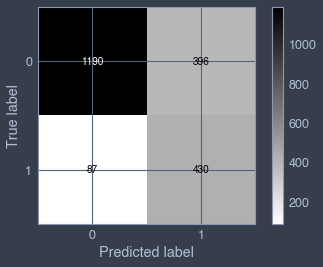

In [380]:
# Confusion matrix
plot_confusion_matrix(loreg_best, X_test, y_test, cmap='binary')

plt.show()

Here we have the confusion matrix in which we can compare the samples of each class and the class predicted. Our goal is to create a good classificator for class 1 (Churn). This plot shows a good approach to that goal.

#### Random Forest (GridsearchCV)

The second classification algorithm that we are going to use is Random Forest. The steps will be the same as taken with Logistic Regression.

In [369]:
max_depth_generator = [int(x) for x in np.linspace(10,50,5)]
max_depth_generator.append(None)

params = {'n_estimators': [100, 200, 300],
         'criterion': ['gini'],
         'max_depth': max_depth_generator,
         }

rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf_model,
                      param_grid=params)

grid_results = rf_grid.fit(X_train, y_train)

print('Best {} using {}'.format(grid_results.best_score_, grid_results.best_params_))

Best 0.8553331085406557 using {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}


In [386]:
# Grid Results
grid_re = grid_results.cv_results_
cv_results = pd.DataFrame()

for key, value in grid_re.items():
    cv_results[key] = value
    
cv_results.head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.549016,0.011252,0.029083,0.000518,gini,10,100,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.779175,0.788260,0.860936,0.876310,0.874126,0.835762,0.042914,18
1,1.084467,0.007258,0.056546,0.000801,gini,10,200,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.777778,0.795947,0.862334,0.874214,0.879720,0.837999,0.042519,16
2,1.651833,0.075415,0.088044,0.007390,gini,10,300,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.778477,0.792453,0.863732,0.875611,0.879021,0.837859,0.043306,17
3,0.676629,0.004360,0.035113,0.000514,gini,20,100,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",0.784766,0.786862,0.886094,0.894479,0.910490,0.852538,0.055045,4
4,1.328288,0.017408,0.068496,0.000717,gini,20,200,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",0.783368,0.781971,0.889588,0.897275,0.908392,0.852119,0.057021,8


In [420]:
# Random Forest with best params
rf_best = RandomForestClassifier(max_depth=20,
                                 n_estimators=300,
                                 criterion='gini',
                                 random_state=0)

rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=0)

In [419]:
# Random Forest prediction with best params
rf_best_pred = rf_best.predict(X_test)
rf_best_score = rf_best.score(X_test, y_test)
print('Random Forest Accuracy: ',rf_best_score)
print('\nRandom Forest Recall: ', recall_score(y_test, rf_best_pred))

Random Forest Accuracy:  0.8017118402282454

Random Forest Recall:  0.6344294003868471


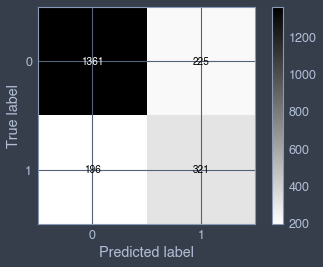

In [410]:
# Confusion matrix
plot_confusion_matrix(rf_best, X_test, y_test, cmap='binary')

plt.show()

Comparing the Recall score of Logistic Regression and Random Forest we can see that Logistic is better using the best parameters in both cases. We will visualize these results better in next steps.

#### AUC & ROC

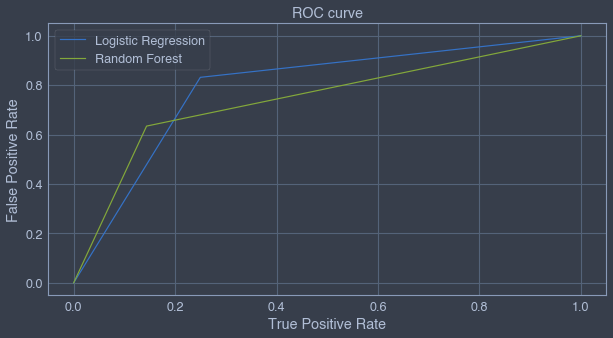

In [421]:
# ROC
fig, axes = plt.subplots(figsize=(10,5))

# Logistic Regression roc 
loreg_fpr, loreg_tpr, _ = roc_curve(y_test, loreg_best_pred)
axes.plot(loreg_fpr, loreg_tpr, label='Logistic Regression')

# Random Forest roc
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_best_pred)
axes.plot(rf_fpr, rf_tpr, label='Random Forest')

axes.set_title('ROC curve')
axes.set_xlabel('True Positive Rate')
axes.set_ylabel('False Positive Rate')
axes.legend()

plt.show()

In [393]:
# Logistic Refression AUC
print('Logistic Regression AUC: ', roc_auc_score(y_test, loreg_best.predict_proba(X_test)[:,1]))
print('Random Forest AUC: ', roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1]))

Logistic Regression AUC:  0.8701842280495925
Random Forest AUC:  0.8420756083818518


ROC curve help us to evaluate how well is classified the positive class. The chart shows that both algorithms don't rate positives as well as ther should.

AUC score represents the probability that a random positive sample (Churn). Logistic Regression has better AUC than Random Forest.